In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [119]:
#qc = rb.randomized_benchmarking_seq()
qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
                                rb_pattern=[[0,1]],
                                length_multiplier=1, seed_offset=0,
                                align_cliffs=False,
                                interleaved_gates=None,
                                is_purity=False)
qc = qc[0][0][0]

In [120]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [121]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [122]:
qasm = qc.qasm()
### if you want to remove all barriers
## qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

#qc = qc.from_qasm_str(qasm)

print("\nPrint QASM:")
print(qasm)


Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
h qr[0];
sdg qr[1];
h qr[1];
cx qr[0],qr[1];
h qr[0];
s qr[0];
h qr[1];
s qr[1];
z qr[1];
barrier qr[0],qr[1];
z qr[1];
sdg qr[1];
h qr[1];
sdg qr[0];
h qr[0];
cx qr[0],qr[1];
h qr[1];
s qr[1];
h qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [123]:
# Draw the circuit
print(qc)

          ┌───┐           ┌───┐┌───┐      ░ ┌─────┐ ┌───┐           ┌───┐┌─┐»
qr_0: |0>─┤ H ├────────■──┤ H ├┤ S ├──────░─┤ Sdg ├─┤ H ├────────■──┤ H ├┤M├»
         ┌┴───┴┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └┬───┬┘┌┴───┴┐┌───┐┌─┴─┐├───┤└╥┘»
qr_1: |0>┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├┤ Z ├─░──┤ Z ├─┤ Sdg ├┤ H ├┤ X ├┤ H ├─╫─»
         └─────┘└───┘└───┘└───┘└───┘└───┘ ░  └───┘ └─────┘└───┘└───┘└───┘ ║ »
 cr_0: 0 ═════════════════════════════════════════════════════════════════╩═»
                                                                            »
 cr_1: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
«              
«qr_0: ────────
«      ┌───┐┌─┐
«qr_1: ┤ S ├┤M├
«      └───┘└╥┘
«cr_0: ══════╬═
«            ║ 
«cr_1: ══════╩═
«              


In [124]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg qr[2];', 'creg cr[2];', Circuit(2 qubits, 9 gates), 'barrier qr[0],qr[1];', Circuit(2 qubits, 9 gates), 'measure qr[0] -> cr[0];', 'measure qr[1] -> cr[1];']
[2, 4]
{'qr': (0, 2)}


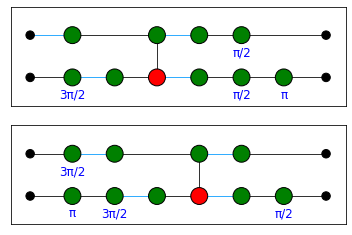

In [125]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)

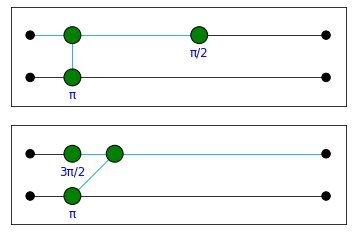

In [126]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [127]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

passedAll = True
for i in range(len(pyzx_circ_list)):
    try:
        assert(pyzx.compare_tensors(pyzx_circ_list[i], circ_list[whichpyzx[i]], False))
    except AssertionError:
        print(i)
        print(circ_list[whichpyzx[i]].__dict__)
        print(pyzx_circ_list[i].__dict__)
        passedAll = False
assert(passedAll)

In [128]:
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


cx q[1], q[0];
z q[1];
rz(0.5*pi) q[0];


rz(1.5*pi) q[0];
cx q[1], q[0];
z q[1];



In [129]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'qr[')
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];

cx qr[1], qr[0];
z qr[1];
rz(0.5*pi) qr[0];
barrier qr[0],qr[1];

rz(1.5*pi) qr[0];
cx qr[1], qr[0];
z qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];


In [130]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [131]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

         ┌───┐┌────────────┐ ░ ┌────────────┐┌───┐┌─┐        
qr_0: |0>┤ X ├┤ Rz(0.5*pi) ├─░─┤ Rz(1.5*pi) ├┤ X ├┤M├────────
         └─┬─┘└───┬───┬────┘ ░ └────────────┘└─┬─┘└╥┘┌───┐┌─┐
qr_1: |0>──■──────┤ Z ├──────░─────────────────■───╫─┤ Z ├┤M├
                  └───┘      ░                     ║ └───┘└╥┘
 cr_0: 0 ══════════════════════════════════════════╩═══════╬═
                                                           ║ 
 cr_1: 0 ══════════════════════════════════════════════════╩═
                                                             


In [132]:
print(qc)

          ┌───┐           ┌───┐┌───┐      ░ ┌─────┐ ┌───┐           ┌───┐┌─┐»
qr_0: |0>─┤ H ├────────■──┤ H ├┤ S ├──────░─┤ Sdg ├─┤ H ├────────■──┤ H ├┤M├»
         ┌┴───┴┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └┬───┬┘┌┴───┴┐┌───┐┌─┴─┐├───┤└╥┘»
qr_1: |0>┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├┤ Z ├─░──┤ Z ├─┤ Sdg ├┤ H ├┤ X ├┤ H ├─╫─»
         └─────┘└───┘└───┘└───┘└───┘└───┘ ░  └───┘ └─────┘└───┘└───┘└───┘ ║ »
 cr_0: 0 ═════════════════════════════════════════════════════════════════╩═»
                                                                            »
 cr_1: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
«              
«qr_0: ────────
«      ┌───┐┌─┐
«qr_1: ┤ S ├┤M├
«      └───┘└╥┘
«cr_0: ══════╬═
«            ║ 
«cr_1: ══════╩═
«              


In [133]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

In [134]:
c1

{'00': 1024}

In [135]:
c2

{'00': 1024}

In [136]:
assert(c1 == c2)

In [137]:
qc.depth()

13

In [138]:
qc.size()

20

In [139]:
new_qc.depth()

6

In [140]:
new_qc.size()

8

In [141]:
new_new_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [142]:
print(new_new_qc)

          ┌──────────┐       ┌──────────────────┐ ░  ┌────────────┐     »
qr_0: |0>─┤ U2(0,pi) ├───■───┤ U3(pi/2,pi/2,pi) ├─░──┤ U2(0,pi/2) ├──■──»
         ┌┴──────────┴┐┌─┴─┐┌┴──────────────────┤ ░ ┌┴────────────┤┌─┴─┐»
qr_1: |0>┤ U2(0,pi/2) ├┤ X ├┤ U3(pi/2,-pi/2,pi) ├─░─┤ U2(0,3pi/2) ├┤ X ├»
         └────────────┘└───┘└───────────────────┘ ░ └─────────────┘└───┘»
 cr_0: 0 ═══════════════════════════════════════════════════════════════»
                                                                        »
 cr_1: 0 ═══════════════════════════════════════════════════════════════»
                                                                        »
«          ┌──────────┐    ┌─┐   
«qr_0: ────┤ U2(0,pi) ├────┤M├───
«      ┌───┴──────────┴───┐└╥┘┌─┐
«qr_1: ┤ U3(pi/2,pi/2,pi) ├─╫─┤M├
«      └──────────────────┘ ║ └╥┘
«cr_0: ═════════════════════╩══╬═
«                              ║ 
«cr_1: ════════════════════════╩═
«                                


In [143]:
new_new_qc.depth()

7

In [144]:
new_new_qc.size()

12

In [145]:
doubly_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(doubly_qc)

         ┌───┐┌──────────┐ ░ ┌───────────┐┌───┐┌─┐             
qr_0: |0>┤ X ├┤ U1(pi/2) ├─░─┤ U1(3pi/2) ├┤ X ├┤M├─────────────
         └─┬─┘└┬────────┬┘ ░ └───────────┘└─┬─┘└╥┘┌────────┐┌─┐
qr_1: |0>──■───┤ U1(pi) ├──░────────────────■───╫─┤ U1(pi) ├┤M├
               └────────┘  ░                    ║ └────────┘└╥┘
 cr_0: 0 ═══════════════════════════════════════╩════════════╬═
                                                             ║ 
 cr_1: 0 ════════════════════════════════════════════════════╩═
                                                               


In [146]:
doubly_qc.depth()

6

In [147]:
doubly_qc.size()

8

In [148]:
c3 = qiskit.execute(new_new_qc, QasmSimulatorPy()).result().get_counts()
c4 = qiskit.execute(doubly_qc, QasmSimulatorPy()).result().get_counts()
c3

{'00': 1024}

In [149]:
c4

{'00': 1024}